In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

API_URL = "https://climate-api.open-meteo.com/v1/climate?"

COORDINATES = {
    "Madrid": {"latitude": 40.416775, "longitude": -3.703790},
    "London": {"latitude": 51.507351, "longitude": -0.127758},
    "Rio": {"latitude": -22.906847, "longitude": -43.172896},
}
VARIABLES = "temperature_2m_mean,precipitation_sum,soil_moisture_0_to_10cm_mean"


def call_API(url):
    try:
        response = requests.get(url)
    except requests.exceptions.Timeout:
        print("Timeout error")
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    
    if 200 == response.status_code:
        return response.json()
    else: print("Status code: ",response.status_code)


def get_data_meteo_api(city):

    full_url = API_URL + "latitude=" + str(COORDINATES[city]["latitude"])
    full_url += "&longitude=" + str(COORDINATES[city]["longitude"])
    full_url += "&start_date=1950-01-01&end_date=2050-12-31"
    full_url += "&models=CMCC_CM2_VHR4,FGOALS_f3_H,HiRAM_SIT_HR,MRI_AGCM3_2_S,EC_Earth3P_HR,MPI_ESM1_2_XR,NICAM16_8S"
    full_url += "&daily=" + VARIABLES
    return call_API(full_url)


def transform_data(dataset):

    dataset = dataset.dropna(axis=1, how='all')
    dataset['Average'] = dataset.mean(axis=1, skipna=True, numeric_only=True)
    dataset['Dispersion'] = dataset.var(axis=1, skipna=True, numeric_only=True)

    dataset['time'] = pd.to_datetime(dataset['time'])
    dataset['year'] = dataset['time'].dt.year

    return dataset
    

def plot_data(data, yaxis):

    yearly_average = data.groupby('year')['Average'].mean().reset_index()
    yearly_variance = data.groupby('year')['Dispersion'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=yearly_average, x='year', y='Average', marker='o',
                 linestyle='-', label=yaxis)

    plt.fill_between(yearly_variance['year'], 
                     yearly_average['Average'] - yearly_variance['Dispersion'], 
                     yearly_average['Average'] + yearly_variance['Dispersion'], 
                     color='lightblue', alpha=0.5, label='Dispersion')

    plt.xlabel('Year')
    plt.ylabel(yaxis)
    plt.title(yaxis)
    plt.legend()
    plt.grid(True)

    plt.show()


json_file = get_data_meteo_api("Madrid")
df = pd.DataFrame(json_file['daily'])
df_soilmoist = df.iloc[:, 0::3]
df_tempmean = pd.concat([df.iloc[:, 0], df.iloc[:, 1::3]], axis=1)
df_precipitation = pd.concat([df.iloc[:, 0], df.iloc[:, 2::3]], axis=1)

df_soilmoist = transform_data(df_soilmoist)
df_tempmean = transform_data(df_tempmean)
df_precipitation = transform_data(df_precipitation)

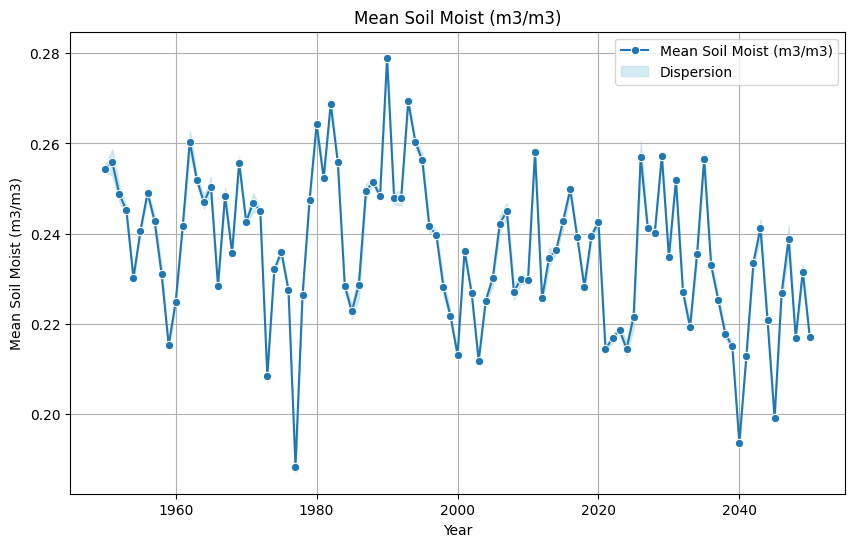

In [2]:
plot_data(df_soilmoist, "Mean Soil Moist (m3/m3)")

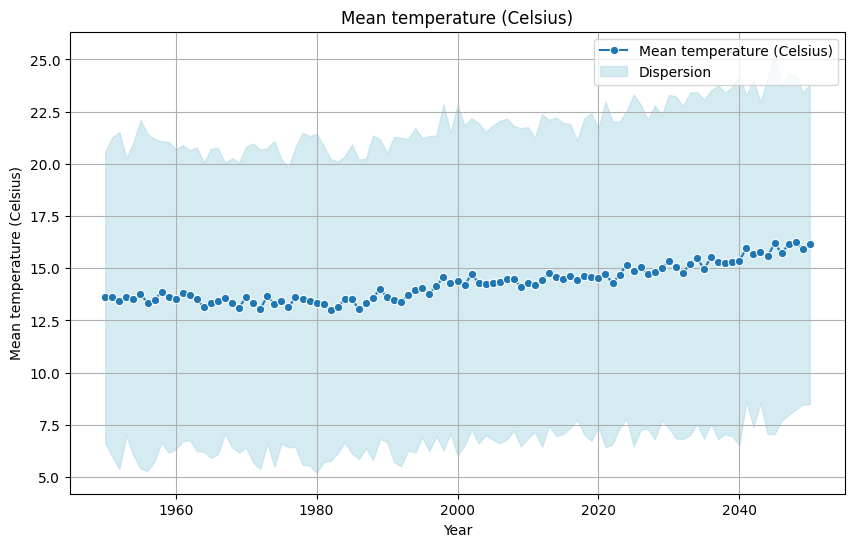

In [3]:
plot_data(df_tempmean, "Mean temperature (Celsius)")

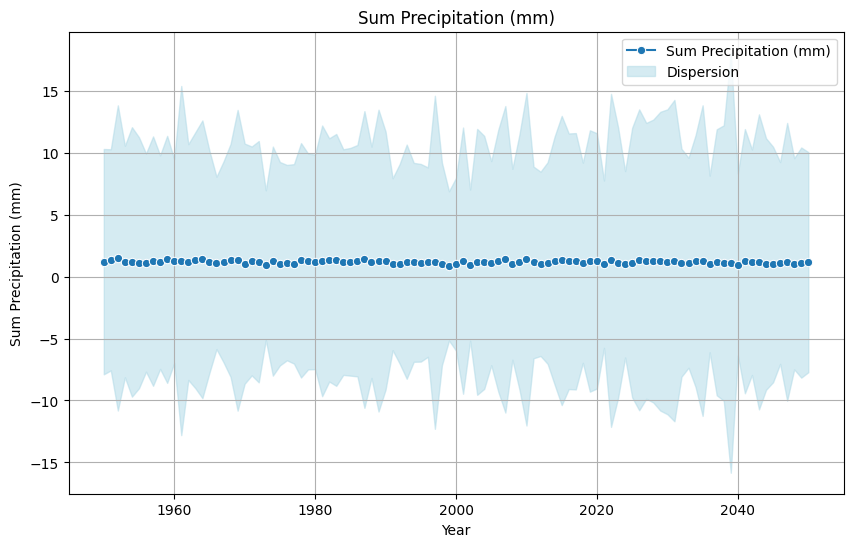

In [4]:
plot_data(df_precipitation, "Sum Precipitation (mm)")